In [1]:
import os
import tensorflow as tf
import sklearn as sk
from tensorflow import keras

from sklearn import manifold
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
import functools
import numpy as np
import pandas as pd
from scipy.special import expit

import sklearn as sk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
import tensorflow as tf

def split_companies_train_dev_test(companies):
    "Return train, dev, test set for companies"
    train, test = train_test_split(companies, test_size=0.1, stratify = companies.sector)
    train, dev = train_test_split(train, test_size=0.1, stratify = train.sector)
    return train, dev, test


def filter_stocks(stocks, tickers):
    return stocks.loc[tickers]


def df_to_ts(df):
    res = df.copy()
    res.index = pd.DatetimeIndex(pd.to_datetime(res.date))
    res.drop('date', axis=1)
    return res


def load_data(stock_filename=None, indices_filename=None):

    if stock_filename is None:
        stock_filename = '../../data/processed/wiki_stocks_returns.csv'

    if indices_filename is None:
        indices_filename = '../../data/processed/wiki_indices_returns.csv'

    stocks = pd.read_csv(stock_filename, index_col=False) # long format
    indices = pd.read_csv(indices_filename, index_col=False) # wide format

    # Implementation of hierarchical clustering
    drop_column = lambda df,i=0: df.drop(df.columns[i], axis=1)

    stocks = drop_column(stocks)
    stocks = stocks.drop('name', axis=1)
    stocks = stocks.dropna()

    companies = stocks.groupby('ticker').first().reset_index()
    sectors_unique = sorted({}.fromkeys(companies.sector).keys())
    stocks = stocks.set_index('ticker')

    indices_ts = df_to_ts(indices[['date'] + sectors_unique])
    stocks_ts = df_to_ts(stocks.reset_index())

    stocks_all = pd.merge(stocks_ts, indices_ts, 'left')
    stocks_all = stocks_all.dropna() # loss of 200 000 observations
    stocks_all = stocks_all.drop('sector', axis=1)
    stocks_all = stocks_all.groupby('ticker').apply(df_to_ts)
    stocks_all = stocks_all.drop(['ticker', 'date'], axis=1)
    stocks_all = stocks_all.rename(columns={'close': 'pct_return'})

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(sectors_unique)
    ticker_to_sector = dict(
        zip(companies.ticker, label_encoder.transform(companies.sector)))

    return stocks_all, companies, label_encoder, ticker_to_sector


def sectors_statistics(companies):
    sectors_counts = companies.sector.value_counts()
    sectors_proportions = sectors_counts/sectors_counts.sum()
    sectors_unique = sorted(sectors_counts.index.tolist())
    return sectors_counts, sectors_proportions, sectors_unique

def random_subset(df, window_size=21):
    if df.shape[0]-window_size < 0:
        return df
    idx = np.random.randint(0, df.shape[0]-window_size)
    ts = df[idx:idx+window_size]
    return ts


class StocksSequence(keras.utils.Sequence):

    def __init__(self, stocks_data,  companies_data, window_size, label_encoder,
                 batch_size, mode_key='train'):
        self.stocks_data = stocks_data
        self.batch_size = batch_size
        self.label_encoder = label_encoder
        self.companies_data = companies_data
        self.window_size = window_size
        self.mode_key = mode_key
        self.classes = []     
        _, sectors_proportion, _ = sectors_statistics(companies_data)
        scores = sectors_proportion.shape/sectors_proportion
        scores = scores/scores.sum()
        scores = scores.reset_index(0)
        scores.columns = ['sector', 'sample_prob']
        probs = companies_data.merge(scores, on='sector').sample_prob
        self.companies_sample_probabilities = probs/probs.sum()

    def __len__(self):
        return int(np.ceil(self.stocks_data.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.choice(
            self.companies_data.shape[0], self.batch_size, 
            p=self.companies_sample_probabilities)
        df = self.companies_data.iloc[idx]
        model_input_data = [
            random_subset(self.stocks_data.loc[t], self.window_size) 
            for t in df.ticker
        ]
        model_input = np.array([df.values for df in model_input_data])
        if self.mode_key != 'infer':
            y_true = self.label_encoder.transform(df.sector)

        if self.mode_key == 'infer':
            if 'sector' in df.columns:
                self.classes.extend(self.label_encoder.transform(df.sector))

        if self.mode_key == 'infer':
            return model_input

        return model_input, y_true


In [3]:
def normalize_tensor(x):
    """
    x: a B x T x F tensor
    """
    epsilon = 1e-16
    m, s = tf.nn.moments(x, axes=[1], keep_dims=True)
    z = (x - m)/(tf.sqrt(s)+epsilon)
    return z


def correlation_function(x):
    x_normalized = normalize_tensor(x)
    correlations = tf.keras.backend.batch_dot(
        x_normalized, tf.transpose(x_normalized, [0, 2, 1]), axes=[1, 2])
    correlations = correlations/tf.cast(tf.shape(x_normalized)[1], tf.float32)
    return correlations


def correlation_roll(x):
    x_normalized = normalize_tensor(x)
    cross_product = x_normalized[:, :, 0, tf.newaxis] * x_normalized[:, :, 1:]
    cross_product = cross_product/tf.cast(tf.shape(x_normalized)[1], tf.float32)
    return cross_product

In [4]:
tf.reset_default_graph()
model = keras.models.load_model('checkpoint/model_weights_thirtyfourth.json')

In [5]:
stocks_all, companies, label_encoder, ticker_to_sector = load_data(
    '../data/processed/wiki_stocks_returns.csv',
    '../data/processed/wiki_indices_returns.csv')

sectors_counts, sectors_proportions, sectors_unique = sectors_statistics(companies)
companies_data = {}

np.random.seed(42)
data_split = split_companies_train_dev_test(companies)
for i, k in enumerate(['train', 'dev', 'test']):
    companies_data[k] = data_split[i]
stocks_data = {k: filter_stocks(stocks_all, v.ticker) for k, v in companies_data.items()}

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series_input (InputLayer)       (None, 63, 18)       0                                            
__________________________________________________________________________________________________
gaussian_noise_9 (GaussianNoise (None, 63, 18)       0           series_input[0][0]               
__________________________________________________________________________________________________
lambda_81 (Lambda)              (None, 63, 18)       0           gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
lambda_80 (Lambda)              (None, 63, 17)       0           gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
lambda_82 

In [7]:
from IPython.display import SVG
from tensorflow.keras import utils as keras_utils

keras_utils.plot_model(model, 'model_keras.png')


# Classification with a single period

In the following section, we create our analysis with the prediction based on a single sample period.

In [38]:
sequence_generator_test = StocksSequence(
    stocks_data['test'], companies_data['test'], 63, label_encoder, 256, 'eval')
y = model.evaluate_generator(sequence_generator_test, 300)

sequence_generator_infer = StocksSequence(
    stocks_data['test'], companies_data['test'], 63, label_encoder, 256, 'infer')

prediction = model.predict_generator(sequence_generator_infer, 300)

In [39]:
y_pred = np.argmax(prediction, 1)
y_true = np.array(sequence_generator_infer.classes[:y_pred.shape[0]])


conf_mat = confusion_matrix(y_true, y_pred)

conf_df = pd.DataFrame(conf_mat, columns=label_encoder.classes_.tolist(), index=label_encoder.classes_.tolist())
conf_df.to_csv('confusion_matrix.csv')
conf_df_ratio = conf_df.apply(lambda x: 100*round(x/x.sum(), 4), 0)
conf_df_ratio.to_csv('confusion_matrix_ratio.csv')

In [40]:
conf_df

,Business Services,Chemicals,Communication Equipment,Communication Services,Consumer Packaged Goods,Drug Manufacturers,Entertainment,Financial Services,Industrial Products,Insurance,Manufacturing - Apparel & Furniture,Medical,Oil and Gas,REITs,Retail - Apparel & Specialty,Technology,Utilities
Business Services,1175,69,36,75,198,299,77,577,216,21,9,677,91,176,435,222,121
Chemicals,15,1455,3,27,143,1,25,81,260,31,7,218,130,21,118,54,73
Communication Equipment,2,8,485,13,5,1,13,18,11,0,0,35,8,11,63,248,5
Communication Services,7,21,60,1006,39,7,24,123,94,35,2,131,30,40,105,329,254
Consumer Packaged Goods,16,81,14,82,1881,40,61,106,162,39,9,390,171,33,266,102,262
Drug Manufacturers,6,18,27,20,75,490,43,53,50,7,0,552,32,4,68,92,66
Entertainment,15,21,8,88,59,5,1309,141,53,22,9,154,15,58,144,200,43
Financial Services,26,78,20,68,115,6,106,6416,218,310,16,507,118,160,594,266,217
Industrial Products,57,204,16,58,60,14,34,222,2021,45,39,414,101,97,287,307,115
Insurance,35,61,10,31,64,10,24,436,104,948,10,312,105,141,233,147,136


In [41]:
conf_df_ratio

,Business Services,Chemicals,Communication Equipment,Communication Services,Consumer Packaged Goods,Drug Manufacturers,Entertainment,Financial Services,Industrial Products,Insurance,Manufacturing - Apparel & Furniture,Medical,Oil and Gas,REITs,Retail - Apparel & Specialty,Technology,Utilities
Business Services,73.99,2.99,3.06,3.85,6.17,28.67,3.28,6.15,4.94,1.31,0.72,5.79,1.32,3.26,5.04,2.61,2.20
Chemicals,0.94,63.15,0.26,1.39,4.45,0.10,1.06,0.86,5.95,1.93,0.56,1.87,1.89,0.39,1.37,0.64,1.33
Communication Equipment,0.13,0.35,41.28,0.67,0.16,0.10,0.55,0.19,0.25,0.00,0.00,0.30,0.12,0.20,0.73,2.92,0.09
Communication Services,0.44,0.91,5.11,51.62,1.21,0.67,1.02,1.31,2.15,2.18,0.16,1.12,0.44,0.74,1.22,3.87,4.63
Consumer Packaged Goods,1.01,3.52,1.19,4.21,58.58,3.84,2.60,1.13,3.71,2.43,0.72,3.34,2.48,0.61,3.08,1.20,4.77
Drug Manufacturers,0.38,0.78,2.30,1.03,2.34,46.98,1.83,0.57,1.14,0.44,0.00,4.72,0.46,0.07,0.79,1.08,1.20
Entertainment,0.94,0.91,0.68,4.52,1.84,0.48,55.75,1.50,1.21,1.37,0.72,1.32,0.22,1.08,1.67,2.35,0.78
Financial Services,1.64,3.39,1.70,3.49,3.58,0.58,4.51,68.44,4.99,19.31,1.28,4.34,1.71,2.97,6.88,3.13,3.95
Industrial Products,3.59,8.85,1.36,2.98,1.87,1.34,1.45,2.37,46.24,2.80,3.13,3.54,1.47,1.80,3.32,3.61,2.10
Insurance,2.20,2.65,0.85,1.59,1.99,0.96,1.02,4.65,2.38,59.07,0.80,2.67,1.52,2.61,2.70,1.73,2.48


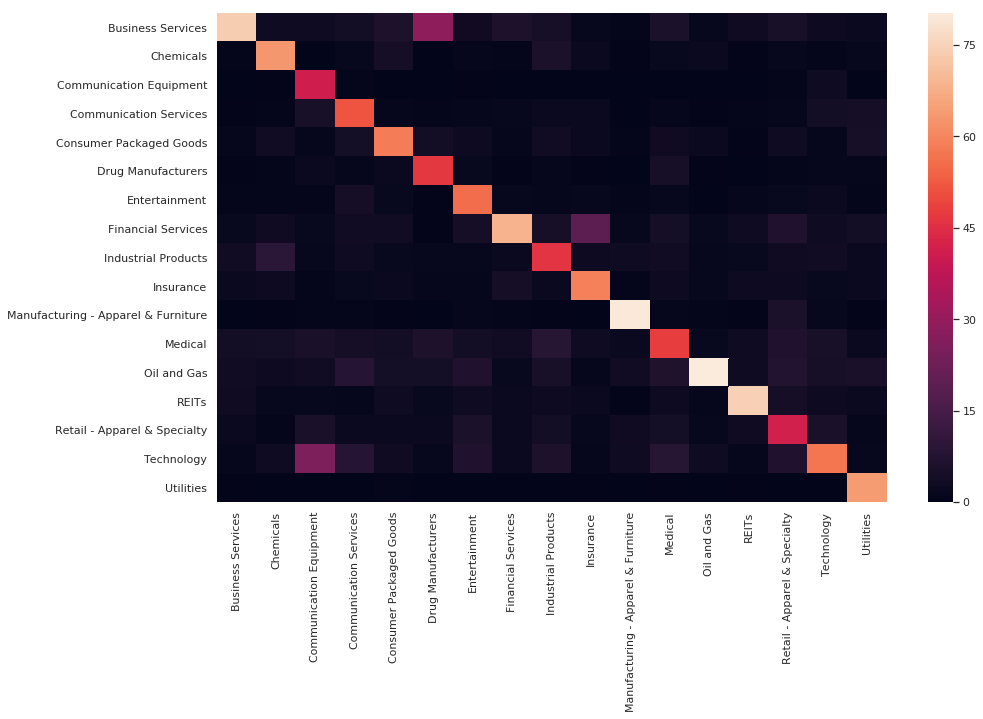

In [42]:
import seaborn as sns
import matplotlib.pylab as plt
sns.set()
plt.rcParams['figure.figsize'] = (15, 9)
sns_plot = sns.heatmap(conf_df_ratio)
sns_plot.figure.savefig('confusion_matrix.png', width=20, height=9)
plt.show()

In [43]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_.tolist()))

                                     precision    recall  f1-score   support

                  Business Services       0.74      0.26      0.39      4474
                          Chemicals       0.63      0.55      0.59      2662
            Communication Equipment       0.41      0.52      0.46       926
             Communication Services       0.52      0.44      0.47      2307
            Consumer Packaged Goods       0.59      0.51      0.54      3715
                 Drug Manufacturers       0.47      0.31      0.37      1603
                      Entertainment       0.56      0.56      0.56      2344
                 Financial Services       0.68      0.69      0.69      9241
                Industrial Products       0.46      0.49      0.48      4091
                          Insurance       0.59      0.34      0.43      2807
Manufacturing - Apparel & Furniture       0.80      0.49      0.61      2031
                            Medical       0.48      0.67      0.56      833

# Classification of a time series with multiple periods 

In the following we sample an input 50 times and make prediction on each of the sample and then use the most predicted classes as our predictor.


In [44]:
class ClassPredictor:
    """
    Predicts the class of a stocks
    """
    def __init__(self, model, window_size, prediction_sample=10, mode_key='train'):
        self.model = model
        self.window_size = window_size
        self.mode_key = mode_key
        self.prediction_sample = prediction_sample

    def predict(self, stocks_data):
        model = self.model
        batch_df_data = [random_subset(stocks_data, self.window_size) for i in range(self.prediction_sample)]
        batch_data = np.array([df.values for df in batch_df_data])
        correlation = np.array([np.corrcoef(x.T + 0.001*np.random.randn(*x.T.shape))[0, 1:] for x in batch_data])
        
        return model.predict_on_batch([batch_data])

    def predict_class(self, keras_output):
        return pd.DataFrame(np.argmax(np.array(keras_output), 2)).apply(
            lambda s: np.argmax(s.value_counts()), 1)

class_predictor = ClassPredictor(model, 63, 50, 'predict')
df = stocks_data['test']
companies = companies_data['test']

res = []
for t in companies.ticker:
    res.append(class_predictor.predict(df.loc[t]))

predictions = class_predictor.predict_class(res)


In [45]:
y_true = label_encoder.transform(companies.sector)
print(classification_report(y_true, predictions.values, target_names=label_encoder.classes_.tolist()))


                                     precision    recall  f1-score   support

                  Business Services       1.00      0.67      0.80         3
                          Chemicals       1.00      1.00      1.00         3
            Communication Equipment       1.00      1.00      1.00         2
             Communication Services       1.00      0.50      0.67         2
            Consumer Packaged Goods       1.00      1.00      1.00         4
                 Drug Manufacturers       0.00      0.00      0.00         2
                      Entertainment       1.00      1.00      1.00         3
                 Financial Services       1.00      1.00      1.00        10
                Industrial Products       1.00      1.00      1.00         5
                          Insurance       1.00      1.00      1.00         3
Manufacturing - Apparel & Furniture       1.00      1.00      1.00         3
                            Medical       0.67      1.00      0.80         

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
stocks_data_all = pd.concat( [stocks_data['train'], stocks_data['dev'],
                              stocks_data['test']], 0)

companies_data_all = pd.concat([companies_data['train'], companies_data['dev'],
                           companies_data['test']], 0)

In [47]:
layer = model.get_layer('Embedding')
model_embedding = keras.models.Model(model.input, layer.output)

sequence_generator_infer = StocksSequence(
    stocks_data_all, companies_data_all, 63, label_encoder, 256, 'infer')

model_embedding.predict_generator(sequence_generator_infer, 20)

embedding_predictor = ClassPredictor(model_embedding, 63, 25, 'predict')

res = [embedding_predictor.predict(stocks_data_all.loc[t]) for t in companies_data_all.ticker]

average_embedding = np.mean(np.array(res), axis=1)

In [48]:
metadata_path = 'logs/embedding/metadata.tsv'
companies_data_all[['ticker', 'sector']].to_csv(metadata_path, sep='\t', index=False)

In [49]:
# tf.reset_default_graph()
with tf.variable_scope('embedding', reuse=tf.AUTO_REUSE):
    embedding_variable = tf.get_variable(
        'stock_embedding', 
        initializer=tf.constant(np.array(average_embedding)))

In [50]:
projector = tf.contrib.tensorboard.plugins.projector

## Running TensorFlow Session
with tf.Session() as sess:
    saver = tf.train.Saver([embedding_variable])
    sess.run(embedding_variable.initializer)
    saver.save(sess, os.path.join('logs/embedding', 'embedding_variable.ckpt'))
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_variable.name
    # Link this tensor to its metadata(Labels) file
    embedding.metadata_path = './metadata.tsv'
    # Saves a config file that TensorBoard will read during startup.

    projector.visualize_embeddings(tf.summary.FileWriter('logs/embedding'), config)


In [51]:
tsne_points = manifold.TSNE(
    perplexity=50, learning_rate=10, 
    n_iter=1000).fit_transform(average_embedding)

In [52]:
tsne_df = pd.DataFrame(tsne_points, columns=['x', 'y'])
tsne_df['sector'] = companies_data_all.sector.values

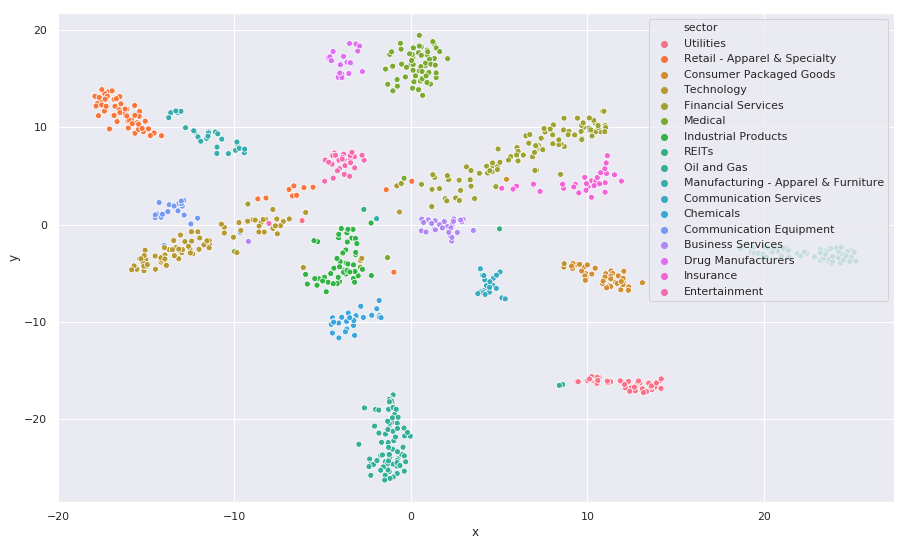

In [53]:
plt.rcParams['figure.figsize'] = (15, 9)
sns_plot = sns.scatterplot(x='x', y='y', hue='sector', data=tsne_df)
plt.show()

In [54]:
sns_plot.figure.savefig('tsne.png')

# Analysis

Usually the clusert a well separated. Financial services and REITs are well
separated and easily identified. The model seems to have difficulty to
differentiate somes chemical companies as their embedding seems to be close to
some industrial production companies.

In general, the more companies we had in the raw dataset the more precise the
groups are.



For n_clusters = 17 The average silhouette_score is : 0.27233663


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

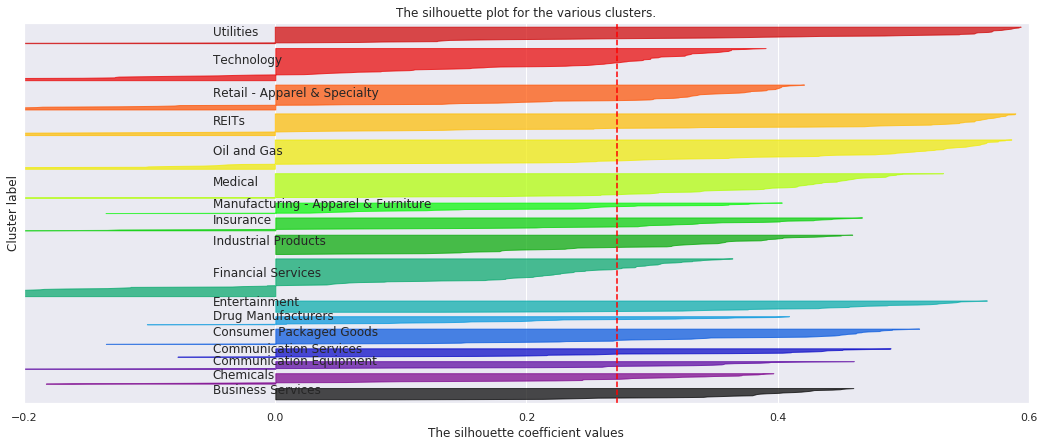

In [55]:
# Silouhette in the embedding space
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = average_embedding
y = companies_data_all.sector

range_n_clusters = [len(label_encoder.classes_)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cluster_labels = label_encoder.transform(y)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, label_encoder.inverse_transform(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])


plt.show()